# The OHMies Voting Power
The Olympus DAO is governed by the OHMies, holders of the protocol-issued tokens. Through the power of the people, the protocol decides which path is best to follow, what changes should be implemented and who to partner with.

In this report we will have a closer look at the votes on proposal *"TAP-11"* and try to learn more about the voting OHMies and their voting power.

## Methodology
The governance voting process takes place on Snapshot. Each individual proposal, as well as the voting tally, is accessible through the Snapshot front-end, and exportable through their GraphQL API:
- Snapshot front-end: [https://snapshot.org/#/olympusdao.eth/](https://snapshot.org/#/olympusdao.eth/proposal/0xe52a4af6307bea40a34f2eaf9a93f11c8abf382020cca2d370ffaa0337620b6b)
- API Documentation: https://docs.snapshot.org/graphql-api
- Production Endpoint: https://hub.snapshot.org/graphql

The data from the API will be imported in this Jupiter Notebook using [Subgrounds](https://github.com/Protean-Labs/subgrounds). It will be further processed as a Pandas DataFrame and visualized using Plotly.

While the votes are not recorded on the blockchain, the platform takes an account balance snapshot before the vote, which will constitute each user's voting power for the proposal. The voting strategy used by the Snapshot space at the time of the proposal allows for the voting power to be accumulated by holding any of the following assets:
- sOHM v1
- sOHM v2
- sOHM v3
- OHM-DAI SLP
- sOHM Multichain LP
- gOHM

The voting on **TAP-11 Ribbon Finance Whitelist** started on `Apr 19, 2022, 10:33 PM` and ended on `Apr 23, 2022, 10:33 AM`.

## Data Import
In the block below we will first import all the modules necessary to pull the data from the API, process and visualize it.

In [1]:
# https://github.com/Protean-Labs/subgrounds
from subgrounds.subgrounds import Subgrounds
from subgrounds.subgraph import SyntheticField
import pandas as pd
from datetime import date, datetime, timedelta
from operator import add
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")

Once imported, the Subgrounds module can be initialized and the Snapshot API loaded in the `snapshot` variable.

In [2]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

Using the unique `proposal_id` of the proposal, we can pull the relevant voting data through the API. Before doing so however, we are going to create a couple of synthetic fields to help with the data. By doing so, we can rely on Subgrounds to transform the timestamps into datetime and to label the vote options from a binary format.

In [3]:
proposal_id = '0xe52a4af6307bea40a34f2eaf9a93f11c8abf382020cca2d370ffaa0337620b6b'

snapshot.Vote.date_vote = SyntheticField(
    f = lambda timestamp: str(date.fromtimestamp(timestamp)),
    type_ = SyntheticField.STRING,
    deps = snapshot.Vote.created
)

snapshot.Vote.voter_choice = SyntheticField(
    f = lambda x: 'Allow Ribbon Finance' if x == 1 else 'Do not allow Ribbon Finance',
    type_ = SyntheticField.STRING,
    deps = snapshot.Vote.choice
)

proposal = snapshot.Query.proposal(
    id = proposal_id
)

votes = snapshot.Query.votes(
    first = 226,
    orderBy = 'created',
    orderDirection = 'asc',
    where = {
        'proposal': proposal_id
    }
)

The first DataFrame to be constructed is of the voting power split among the possible assets that can grant it. This information will be stored in the `proposal_scores_by_strat` df.

In [4]:
proposal_scores_strat = sg.query_json([
    proposal.scores_by_strategy
    ])
scores_by_strategy = list(map(
    add, 
    proposal_scores_strat[0]['x00695cf9dbf02ec0']['scores_by_strategy'][0], 
    proposal_scores_strat[0]['x00695cf9dbf02ec0']['scores_by_strategy'][1]
    )
)
strat_names = ['sOHM v1', 'OHM-DAI SLP', 'sOHM v2', 'sOHM v3', 'sOHM Multichain LP', 'gOHM']

proposal_scores_by_strat = pd.DataFrame(
    data= {'votes': scores_by_strategy, 'asset': strat_names}, 
    columns= ['asset','votes'])
proposal_scores_by_strat

,asset,votes
0,sOHM v1,9.100000e-08
1,OHM-DAI SLP,2.000000e-18
2,sOHM v2,1.246084e+01
3,sOHM v3,6.582513e+04
4,sOHM Multichain LP,1.168486e+04
5,gOHM,3.868778e+05


The second DataFrame will hold more in-detail data about the voters. Individual voter address, date of the vote, address voting power, their choice and how much voting power thei have by asset. This will be stored in the `proposal_votes` df.

In [5]:
proposal_votes = sg.query_df([
    votes.voter,
    votes.date_vote,
    votes.voter_choice,
    votes.vp
])
vp_by_strategy_json = sg.query_json([votes.vp_by_strategy])[0]['x32eae029ffc2c5f8']

vp_by_strategy = {
    'sOHM v1': [], 
    'OHM-DAI SLP': [], 
    'sOHM v2': [], 
    'sOHM v3': [], 
    'sOHM Multichain LP': [], 
    'gOHM': []
}

for i in range(0, len(vp_by_strategy_json)):
    vp_by_strategy['sOHM v1'].append(vp_by_strategy_json[i]['vp_by_strategy'][0]),
    vp_by_strategy['OHM-DAI SLP'].append(vp_by_strategy_json[i]['vp_by_strategy'][1]),
    vp_by_strategy['sOHM v2'].append(vp_by_strategy_json[i]['vp_by_strategy'][2]),
    vp_by_strategy['sOHM v3'].append(vp_by_strategy_json[i]['vp_by_strategy'][3]),
    vp_by_strategy['sOHM Multichain LP'].append(vp_by_strategy_json[i]['vp_by_strategy'][4]),
    vp_by_strategy['gOHM'].append(vp_by_strategy_json[i]['vp_by_strategy'][5])

for key in vp_by_strategy.keys():
    proposal_votes[key] = vp_by_strategy[key]

proposal_votes.head()

,votes_voter,votes_date_vote,votes_voter_choice,votes_vp,sOHM v1,OHM-DAI SLP,sOHM v2,sOHM v3,sOHM Multichain LP,gOHM
0,0xd0bB63e2c183DB414977Eaa6B547601e46E12ed4,2022-04-19,Allow Ribbon Finance,4.310303,0.0,0.0,0.0,4.310303,0.0,1.144218e-09
1,0x8e7742209bf49b7bf2A7007Faa669F8A4cfbbF25,2022-04-19,Allow Ribbon Finance,195.214866,0.0,0.0,0.0,0.000000,0.0,1.952149e+02
2,0xa100cD30f2384E53d149729Db33a84597c296c3d,2022-04-19,Allow Ribbon Finance,264.313736,0.0,0.0,0.0,0.000000,0.0,2.643137e+02
3,0xca6aA0576c2ADc79d2c20e6D53c07f590f62932A,2022-04-19,Do not allow Ribbon Finance,2925.506853,0.0,0.0,0.0,0.000000,0.0,2.925507e+03
4,0x16ff8Ad104Fa6195260A6d4A3F311c5f120dF77d,2022-04-19,Do not allow Ribbon Finance,1143.197250,0.0,0.0,0.0,0.000000,0.0,1.143197e+03


## Results
The voters had to choose from two options:
1. Allow Ribbon Finance
2. Do not allow Ribbon Finance

At the end of the voting period, **226 votes** were casted, and the winning option was to *Allow Ribbon Finance* with **52.4% of the total voting power** in favor.

In this case the popular vote closely resembles the result of the vote. The option to *Allow Ribbon Finance* was chosen by **122 voters**, or 54% of the participants.

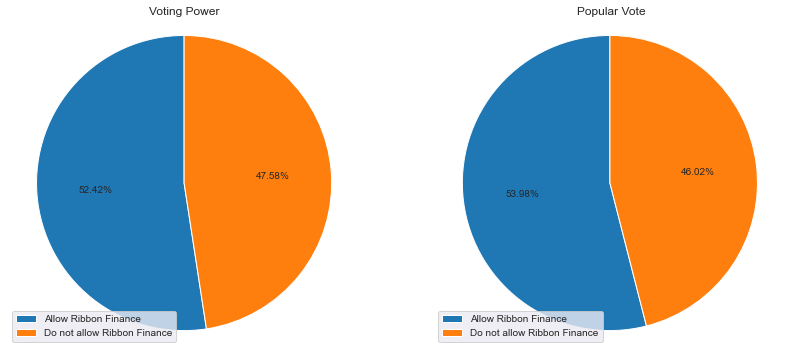

In [6]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(1,2,1)
votes_vp = proposal_votes.groupby('votes_voter_choice').votes_vp.sum().reset_index()
plt.pie(votes_vp.votes_vp, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.legend(labels=votes_vp.votes_voter_choice, loc='lower left')
plt.title('Voting Power')

ax2 = plt.subplot(1,2,2)
votes_pop = proposal_votes.groupby('votes_voter_choice').votes_voter.count().reset_index()
plt.pie(votes_pop.votes_voter, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.legend(labels=votes_pop.votes_voter_choice, loc='lower left')
plt.title('Popular Vote')
plt.show()

The daily barchart below allows us to observe the voting process by the chosen option. After the first few days of people mostly opting for the second option, the results turned around with a massive and consistent vote for the first option over the last two days.

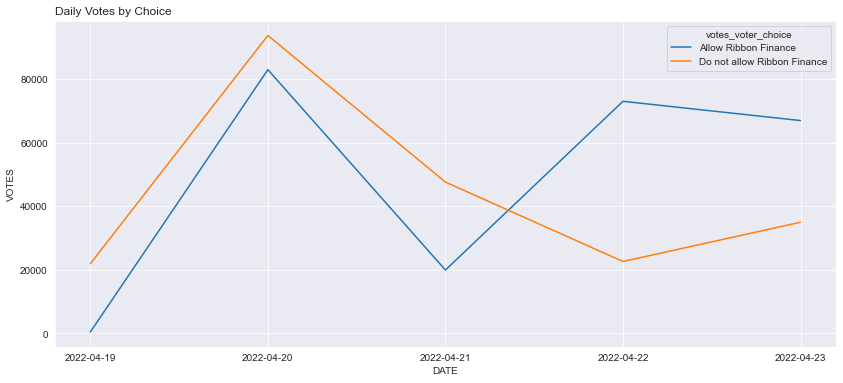

In [7]:
plt.figure(figsize=(14,6))
votes_timeline = proposal_votes.groupby(['votes_date_vote','votes_voter_choice'])\
    .votes_vp.sum().reset_index()
# votes_timeline
sns.lineplot(data= votes_timeline, x='votes_date_vote', y='votes_vp', hue='votes_voter_choice')
plt.xlabel('DATE')
plt.ylabel('VOTES')
plt.title('Daily Votes by Choice', loc='left')
plt.show()

Most of the voters, regardless of their option, have a voting power between 0 and 1000. Further exploring the distribution, we can see there is no major discrepancy between the voting power of either option's supporters.

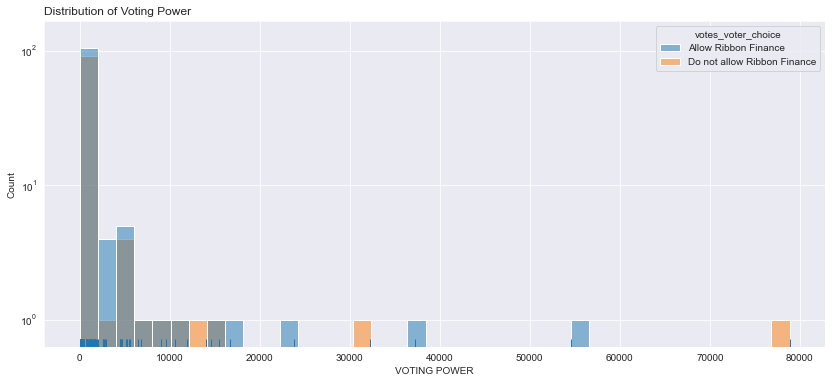

In [8]:
plt.figure(figsize=(14,6))
ax = plt.subplot()
sns.histplot(data=proposal_votes, x='votes_vp', bins=39, log_scale=(False, True), hue='votes_voter_choice')
sns.rugplot(proposal_votes.votes_vp)
plt.xticks(range(0,90000,10000))
plt.xlabel('VOTING POWER')
plt.title('Distribution of Voting Power', loc='left')
plt.show()

Out of all 6 tokens that can be held to gain voting power, over 80% was obtained through **gOHM**. The OHMies second favorite token is the **sOHM v3**, the current iteration of the staked OHM, with over 14% of the voting power used.

The sOHM v1 and v2 tokens have been phased out with the introduction of the v3 and gOHM and for this reason only a handful of those are still circulating and being used for governance. 

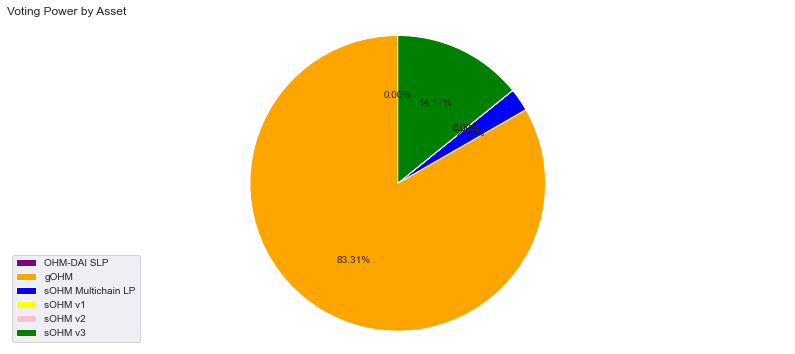

In [9]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot()
votes_vp = proposal_scores_by_strat.groupby('asset').votes.sum().reset_index()
plt.pie(votes_vp.votes, autopct='%0.2f%%', startangle=90, colors=['purple','orange','blue','yellow','pink','green'])
plt.axis('equal')
plt.legend(labels=votes_vp.asset, loc='lower left')
plt.title('Voting Power by Asset', loc= 'left')
plt.show()

## Conclusions
- The winning option was to *Allow Ribbon Finance* with a 52% majority of votes, option that coincides with the popular choice of the OHMies.
- Most voters hold less than 1,000 Voting Power regardless of their vote.
- Over 80% of the participating voting power was obtained by holding gOHM. The only other significant token by voting power was sOHM v3.